In [1]:
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf


from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_map import SortedConv2DWithMap
from layers.antisym_conv import AntiSymConv2D
from layers.sorted_antisym_filters import SortedAntiSymConv2D

from layers.geometric_confusion import GConfusion
import datetime


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()
#tf.debugging.disable_traceback_filtering()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.is_built_with_xla())
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices("GPU"))
print(tf.__version__ )

Num GPUs Available:  1
True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.11.0-dev20220812


In [3]:
input_net = Input((32, 32, 3))

y = SortedAntiSymConv2D(filters=8, activation=ReLU(), padding='SAME')(input_net)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
#y = GConfusion(patch_size=8, prob=0.4, max=10.0)(y)


y = AntiSymConv2D(filters=16, activation=ReLU(), padding='SAME')(y)
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 
#y = GConfusion(patch_size=8, prob=0.4, max=10.0)(y)

y = AntiSymConv2D(filters=32, activation=ReLU(), padding='SAME')(y)



y = layers.Flatten()(y)
y = layers.Dense(256, activation=ReLU())(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_anti_sym_conv2d (Sor  (None, 32, 32, 8)        32        
 tedAntiSymConv2D)                                               
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 anti_sym_conv2d (AntiSymCon  (None, 16, 16, 16)       528       
 v2D)                                                            
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                         

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


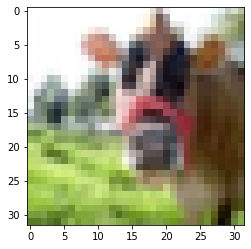

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [5]:
model = Model(inputs = input_net, outputs = output_net)


optimizer = tf.keras.optimizers.RMSprop()


model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)



batch_size = 256
epochs = 30
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
196/196 [==============================] - 11s 32ms/step - loss: 5.7583 - accuracy: 0.0279 - top-5-accuracy: 0.1009 - val_loss: 4.4169 - val_accuracy: 0.0423 - val_top-5-accuracy: 0.1544
Epoch 2/30
196/196 [==============================] - 6s 28ms/step - loss: 4.1950 - accuracy: 0.0753 - top-5-accuracy: 0.2155 - val_loss: 4.0981 - val_accuracy: 0.0983 - val_top-5-accuracy: 0.2617
Epoch 3/30
196/196 [==============================] - 5s 27ms/step - loss: 3.7917 - accuracy: 0.1349 - top-5-accuracy: 0.3317 - val_loss: 3.8484 - val_accuracy: 0.1363 - val_top-5-accuracy: 0.3403
Epoch 4/30
196/196 [==============================] - 5s 26ms/step - loss: 3.5015 - accuracy: 0.1840 - top-5-accuracy: 0.4183 - val_loss: 3.5982 - val_accuracy: 0.1725 - val_top-5-accuracy: 0.3967
Epoch 5/30
196/196 [==============================] - 5s 26ms/step - loss: 3.2924 - accuracy: 0.2203 - top-5-accuracy: 0.4738 - val_loss: 3.4332 - val_accuracy: 0.2047 - val_top-5-accuracy: 0.4462
Epoch 6/30
196

KeyboardInterrupt: 

In [ ]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
def rotateDataset(x,y, maxRot = 360, h=32, w=32, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    datagen.fit(x.reshape(x.shape[0], 32, 32, 3))
    #out = datagen.flow(x.reshape(x.shape[0], h, w, 1), y.reshape(y.shape[0], -1), batch_size=batch_size)

    out = datagen.flow(x.reshape(x.shape[0], h, w, 3),  y, batch_size=batch_size)


    return  out

In [ ]:
score = model.evaluate(rotateDataset(x_test, y_test, maxRot=90), verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

100/100 [==============================] - 6s 58ms/step - loss: 12.5916 - accuracy: 0.1196 - top-5-accuracy: 0.3122
Test loss: 12.591638565063477
Test accuracy: 0.11959999799728394


In [ ]:


def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

for X,Y in rotateDataset(x_test, batch_size=1, maxRot=360):
    print(np.argmax(Y), np.argmax(model.predict(X)))
    plt.figure(0)  
    get_layer_output = K.function([model.input], model.layers[0].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out[0].shape)
    plt.imshow(layer_out[0], cmap='gray_r')   
    plt.figure(1)  
    get_layer_output = K.function([model.input], model.layers[-1].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out[0].shape)
    plt.imshow(layer_out[0],  cmap='gray_r')   

    break

TypeError: rotateDataset() missing 1 required positional argument: 'y'

In [ ]:

n = 109
X = x_test[n]
print(X.shape)

get_layer_output = K.function([model.input], model.layers[1].output)
out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])

get_layer_output = K.function([model.input], model.layers[2].output)
out_shift = np.array(get_layer_output(np.expand_dims(X, axis=0)))





plt.figure(1)  
print('o', out_shift.shape)
im = plt.imshow(out[:, 10, 5, :], cmap='gray')   
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(2)  
im = plt.imshow(out_shift[:,10, 5, :], cmap='gray')  
#plt.colorbar(im, ticks=range(8), orientation="horizontal")

print(map.shape)
print(map[0, 10, 5])



plt.figure(3)  
im = plt.imshow(X, cmap='gray')  

#plt.colorbar(im, ticks=range(32), orientation="horizontal")
        

plt.figure(4)  
im = plt.imshow(map[0], cmap='gray')  

plt.colorbar(im, ticks=range(32), orientation="horizontal")
        


In [ ]:
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    '''if 'conv' not in layer.name:
        raise ValueError('Layer must be a conv. layer')'''
    # get filter weight
    filters, biases = layer.get_weights()
    print("biases shape : ", biases.shape)
    print("filters shape : ", filters.shape)

    return (filters)
    #print(layer.name, filters.shape)

# I use sobel to determine the dominant orientation of the filter
def getSobelAngle(f):

    s_h = sobel_h(f)
    s_v = sobel_v(f)

    return np.abs((np.degrees(np.arctan2(s_h,s_v))% 360))
def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)

In [ ]:

#import cv2



# Install mayavi and vtk from https://www.lfd.uci.edu/~gohlke/pythonlibs/#vtk
# pip install "wheels package"

from msilib.schema import Error
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

#from sa_decomp_layer import SADecompLayer

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

#tf.__version__
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]



from mayavi  import mlab 

LAYER = 5
filters = get_filter(LAYER)

FILTER = [10] #list(range(filters.shape[-1]))
CHANNEL = list(range(filters.shape[-2]))


thetas = []
for i, channel in enumerate(CHANNEL):
    for filter in FILTER:
        
        f = filters[:,:,:, filter]
        f = f[:,:, channel].numpy()
        s, a = getSymAntiSym(f)
        #print("==========(s)
        #print(a)
        #print(getSobelAngle(f)[1, 1])
        sym_mag = np.linalg.norm(s) 
        anti_mag = np.linalg.norm(a) 

        if anti_mag > 0.000001:

            theta = getSobelAngle(f)
            theta = theta[theta.shape[0]//2, theta.shape[1]//2]
            thetas.append(theta)

plt.hist(thetas, bins=15)
plt.xticks(np.arange(0, 360, step=45), size='small', rotation=0)    

plt.show()
print(len(thetas))
print(thetas)

NameError: name 'get_filter' is not defined

In [7]:
#import cv2



# Install mayavi and vtk from https://www.lfd.uci.edu/~gohlke/pythonlibs/#vtk
# pip install "wheels package"

from msilib.schema import Error
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v

#from sa_decomp_layer import SADecompLayer

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d

#tf.__version__
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]



from mayavi  import mlab 

LAYER = 1
FILTER = [5]# list(range(512))
CHANNEL =  list(range(3))# [0, 100]


RGB = ['R','G','B']

def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    if 'conv' not in layer.name:
        raise ValueError('Layer must be a conv. layer')
    # get filter weights
    filters, biases = layer.get_weights()
    print("biases shape : ", biases.shape)
    print("filters shape : ", filters.shape)

    return (filters)
    #print(layer.name, filters.shape)




def getSobelAngle(f):

    s_h = sobel_h(f)
    s_v = sobel_v(f)

    return np.abs(np.pi - (np.arctan2(s_h,s_v)+(np.pi/2)))

def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)


def normalizeToOne(mat):
    return mat/np.linalg.norm(mat)


# https://www.arduino.cc/reference/en/language/functions/math/map/
def mapToRange(x, min_out, max_out):
    return (x - np.min(x)) * (max_out- min_out) / (np.max(x) - np.min(x)) + min_out

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def spec(N):                                             
    t = np.linspace(-510, 510, N)                                              
    return  tuple(map(tuple,np.clip(np.stack([-t, 510-np.abs(t), t], axis=1), 0, 1)))


print("starting")

filters = get_filter(LAYER)
print("Got filters")
fig = mlab.figure(1)
mlab.clf()

#https://stackoverflow.com/questions/24308049/how-to-plot-proper-3d-axes-in-mayavi-like-those-found-in-matplotlib
lensoffset = 0
xx = yy = zz = np.arange(-1.5,1.5,0.1)
xy = xz = yx = yz = zx = zy = np.zeros_like(xx)    
mlab.plot3d(yx,yy+lensoffset,yz,line_width=0.01,tube_radius=0.01)
mlab.plot3d(zx,zy+lensoffset,zz,line_width=0.01,tube_radius=0.01)
mlab.plot3d(xx,xy+lensoffset,xz,line_width=0.01,tube_radius=0.01)

cursor3d = mlab.points3d(0., 0., 0., mode='axes',
                                color=(0, 0, 0),
                                scale_factor=0.5)


filter_list = dict()
sym_list = dict()
anti_list = dict()

zdata = np.array([])
xdata = np.array([])
ydata = np.array([])

glyphs = dict()


num_filters = filters.shape[-1]
num_channels = len(CHANNEL)
c = np.linspace(0, 255, 256)
for i, channel in enumerate(CHANNEL):  # Each channel (ex R G B)
    #print("i = ", i)
    z = np.array([])
    x = np.array([])
    y = np.array([])

    filter_list[i] = []
    sym_list[i] = []
    anti_list[i] = []


    for filter in FILTER: #each filter in that channel

        f = filters[:,:,:, filter]
        f = f[:,:, channel].numpy()

        sym, anti = getSymAntiSym(f) # getSymAntiSym(normalizeToOne(f))
        sym_mag = np.linalg.norm(sym) 
        anti_mag = np.linalg.norm(anti) 

        theta = getSobelAngle(f)
        theta = theta[theta.shape[0]//2, theta.shape[1]//2]
        print(np.rad2deg(theta), sym_mag, anti_mag)
        # Data for three-dimensional scattered points
        z = np.append(z, sym_mag)
        y = np.append(y, anti_mag*np.sin(theta))
        x = np.append(x, anti_mag*np.cos(theta) )

        filter_list[i].append(f)
        sym_list[i].append(sym)
        anti_list[i].append(anti)
    #print(spec(num_channels), i)
    glyphs[i] = mlab.points3d(x, y, z,  color = spec(num_channels)[i], scale_factor=.1)

    zdata = np.append(zdata, z)
    ydata = np.append(ydata, y)
    xdata = np.append(xdata, x)

    glyph_points = glyphs[i].glyph.glyph_source.glyph_source.output.points.to_array()

print(xdata.shape,ydata.shape,zdata.shape )

#print(zdata.shape, xdata.shape, ydata.shape)
# Every object has been created, we can reenable the rendering.
#fig.scene.disable_render = False

# Here, we grab the points describing the individual glyph, to figure
# out how many points are in an individual glyph.


#points_dict[r] = (i, f, sym, anti)
#print(r.actor.actor._vtk_obj)



'''
Display Functions
'''
#https://docs.enthought.com/mayavi/mayavi/auto/example_select_red_balls.html
def picker_callback(picker_obj):
    fig, ax = plt.subplots(ncols=3)

    for n, g in glyphs.items():
        if picker_obj.actor in g.actor.actors :

            # m.mlab_source.points is the points array underlying the vtk
            # dataset. GetPointId return the index in this array.
            point_id = picker_obj.point_id//glyph_points.shape[0]
                                                                
            # If the no points have been selected, we have '-1'
            if point_id != -1:
                # Retrieve the coordinates coorresponding to that data
                # point
                x, y, z = xdata[point_id], ydata[point_id], zdata[point_id]
                #print(x,y,z, type(point_id), point_id, filter_list.shape)

                f = filter_list.get(n)[point_id]
                sym = sym_list.get(n)[point_id]
                anti_sym = anti_list.get(n)[point_id]

                ax[0].imshow(f, cmap=plt.get_cmap('gray'))
                if LAYER == 1: 
                    ax[0].set_title('Filter : {} , Chanel : {}'.format(point_id, RGB[n]))
                else:
                    ax[0].set_title('Filter : {} , Chanel : {}'.format(point_id, n))
                ax[1].imshow(sym, cmap=plt.get_cmap('gray')) 
                ax[2].imshow(anti_sym, cmap=plt.get_cmap('gray')) 
                fig.show()


picker = fig.on_mouse_pick(picker_callback)

# Decrease the tolerance, so that we can more easily select a precise
# point.
picker.tolerance = 0.01

mlab.show()


starting
biases shape :  (8,)
filters shape :  (3, 3, 3, 8)
Got filters
38.57143 0.0 4.457249
38.57143 5.5879354e-09 1.4693834
141.42857 0.0 0.005131446
(3,) (3,) (3,)
